# fgsm attack

## minst


In [1]:
import argparse
import sys
from torchvision.datasets import MNIST
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN,Sigmoid
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp
from mynn.attack import *

In [2]:
cp.random.seed(42)

train_dataset = MNIST(
    root="dataset",
    train=True,
    transform=basic_mnist_augment(train=True),
    download=False
)
test_dataset = MNIST(
    root="dataset",
    train=False,
    transform=basic_mnist_augment(train=False),
    download=False
)


train_images, train_labels = preprocess(train_dataset)
test_images, test_labels = preprocess(test_dataset)



train_set = (train_images[:50000], train_labels[:50000])

dev_set = (train_images[50000:], train_labels[50000:])
test_images = cp.asarray(test_images)
test_labels = cp.asarray(test_labels)
test_set = (test_images, test_labels)

Model loaded from: best_model_basic\minst_base_lenet\best_model.pickle
Model loaded from: best_models_fgsm\minst-bn-fgsm\best_model.pickle


Evaluating FGSM at different epsilons: 100%|██████████| 25/25 [05:38<00:00, 13.55s/it]


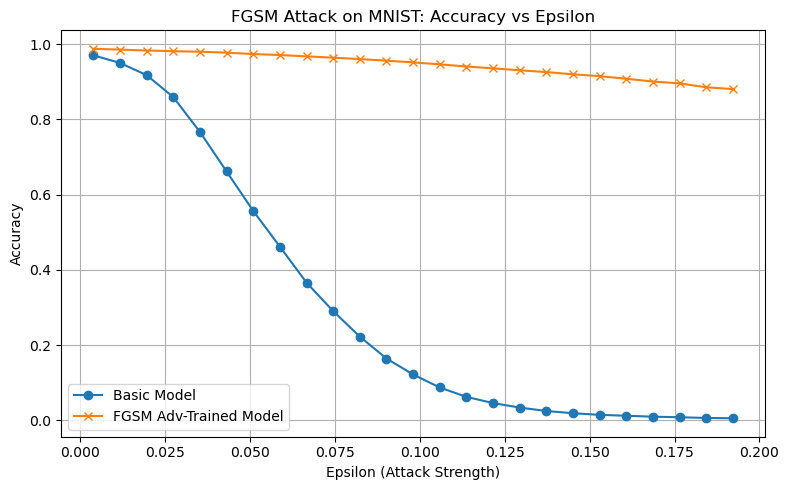

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 已在外部加载好的模型
basicmodel = Model().load_model('best_model_basic/minst_base_lenet/best_model.pickle')
advmodel   = Model().load_model('best_models_fgsm/minst-bn-fgsm/best_model.pickle')

basic_optimizer = Adam(model=basicmodel, lr=0.001)
basic_loss_fn = CrossEntropy(model=basicmodel)
basic_runner = RunnerM(model=basicmodel, loss=basic_loss_fn, optimizer=basic_optimizer)
adv_optimizer = Adam(model=advmodel, lr=0.001)
adv_loss_fn = CrossEntropy(model=advmodel)
adv_runner = RunnerM(model=advmodel, loss=adv_loss_fn, optimizer=adv_optimizer)

# epsilon 范围
epsilons = [i / 255.0 for i in range(1, 51, 2)]

# 记录精度
basic_acc_list = []
adv_acc_list = []

# tqdm进度条
for eps in tqdm(epsilons, desc="Evaluating FGSM at different epsilons"):

    # Basic Model FGSM
    adv_test_images = fgsm_attack(
        model=basicmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=basic_loss_fn,
        epsilon=eps
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # Adv Model FGSM
    adv_test_images = fgsm_attack(
        model=advmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=adv_loss_fn,
        epsilon=eps
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(epsilons, basic_acc_list, label='Basic Model', marker='o')
plt.plot(epsilons, adv_acc_list, label='FGSM Adv-Trained Model', marker='x')
plt.xlabel('Epsilon (Attack Strength)')
plt.ylabel('Accuracy')
plt.title('FGSM Attack on MNIST: Accuracy vs Epsilon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('trades_curve/minst_fgsm_compare')
plt.show()




## cifar10

In [16]:
from torchvision.datasets import MNIST, CIFAR10
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets, cifar10_augment, basic_cifar10_augment
test_dataset = CIFAR10(
    root="../cifar10",
    train=False,
    transform=basic_cifar10_augment(train=False),
    download=False
)
test_images, test_labels = preprocess(test_dataset)
test_images = cp.asarray(test_images)
test_labels = cp.asarray(test_labels)

test_set = (test_images, test_labels)
import numpy as np

print("Min pixel value:", cp.min(test_images))
print("Max pixel value:", cp.max(test_images))

Min pixel value: 0.0
Max pixel value: 1.0


In [5]:
basicmodel = Model().load_model('best_model_basic/VGG-base-train/best_model.pickle')
advmodel=Model().load_model('best_models_fgsm/VGG-adv-train/best_model.pickle')

Model loaded from: best_model_basic\VGG-base-train\best_model.pickle
Model loaded from: best_models_fgsm\VGG-adv-train\best_model.pickle


Evaluating FGSM on CIFAR-10: 100%|██████████| 10/10 [45:26<00:00, 272.68s/it]


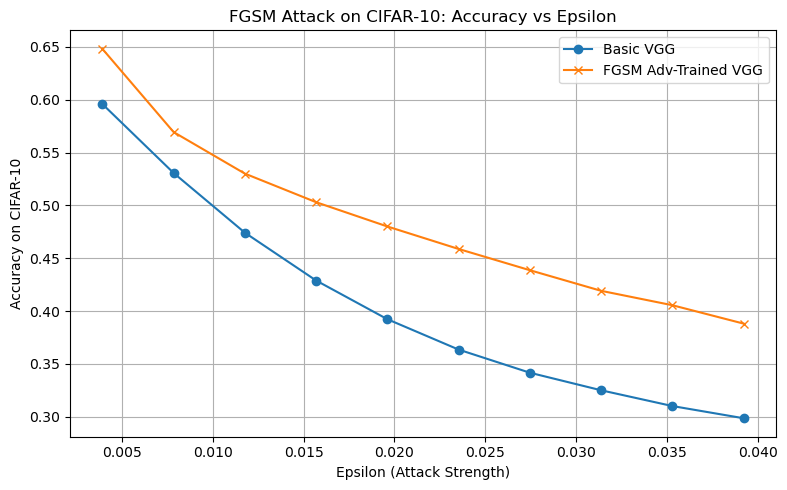

In [6]:
# 构建 runner（不需要重新加载模型）
basic_optimizer = Adam(model=basicmodel, lr=0.001)
basic_loss_fn = CrossEntropy(model=basicmodel)
basic_runner = RunnerM(model=basicmodel, loss=basic_loss_fn, optimizer=basic_optimizer)

adv_optimizer = Adam(model=advmodel, lr=0.001)
adv_loss_fn = CrossEntropy(model=advmodel)
adv_runner = RunnerM(model=advmodel, loss=adv_loss_fn, optimizer=adv_optimizer)

# epsilon 范围
epsilons = [i / 255.0 for i in range(1, 11, 1)]

# 精度记录
basic_acc_list = []
adv_acc_list = []

# 评估各 epsilon 下模型准确率
for eps in tqdm(epsilons, desc="Evaluating FGSM on CIFAR-10"):

    # 基础模型 FGSM
    adv_test_images = fgsm_attack(
        model=basicmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=basic_loss_fn,
        epsilon=eps
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # 对抗训练模型 FGSM
    adv_test_images = fgsm_attack(
        model=advmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=adv_loss_fn,
        epsilon=eps
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(epsilons, basic_acc_list, label='Basic VGG', marker='o')
plt.plot(epsilons, adv_acc_list, label='FGSM Adv-Trained VGG', marker='x')
plt.xlabel('Epsilon (Attack Strength)')
plt.ylabel('Accuracy on CIFAR-10')
plt.title('FGSM Attack on CIFAR-10: Accuracy vs Epsilon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('trades_curve/cifar10_fgsm_compare')
plt.show()

# Trades

## minst

In [3]:
basicmodel = Model().load_model('best_model_basic/minst_base_lenet/best_model.pickle')
advmodel   = Model().load_model('best_model_trades/minst-trade-lenet/best_model.pickle')

Model loaded from: best_model_basic\minst_base_lenet\best_model.pickle
Model loaded from: best_model_trades\minst-trade-lenet\best_model.pickle


In [4]:
from mynn.attack import bim_attack
basic_optimizer = Adam(model=basicmodel, lr=0.001)
loss_fn = CrossEntropy(model=basicmodel)
runner = RunnerM(model=basicmodel, loss=loss_fn, optimizer=basic_optimizer)

adv_test_images = bim_attack(
    model=basicmodel, 
    images=test_images, 
    labels=test_labels, 
    loss_fn=loss_fn,
    epsilon=20/255,
    num_steps=10,
    step_size=4/255
)

test_set_adv = (adv_test_images, test_labels)


In [5]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 5.29541, Test accuracy: 0.08801


In [10]:
from mynn.attack import bim_attack

basic_optimizer = Adam(model=basicmodel, lr=0.001)
loss_fn = CrossEntropy(model=basicmodel)
runner = RunnerM(model=basicmodel, loss=loss_fn, optimizer=basic_optimizer)

adv_test_images = bim_attack(
    model=basicmodel,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=40 / 255,
    num_steps=20,
    step_size=4 / 255
)

test_set_adv = (adv_test_images, test_labels)

adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 15.30391, Test accuracy: 0.00000


In [6]:
from mynn.attack import pgd_attack
basic_optimizer = Adam(model=basicmodel, lr=0.001)
loss_fn = CrossEntropy(model=basicmodel)
runner = RunnerM(model=basicmodel, loss=loss_fn, optimizer=basic_optimizer)

adv_test_images = pgd_attack(
    model=basicmodel, 
    images=test_images, 
    labels=test_labels, 
    loss_fn=loss_fn,
    epsilon=20/255,
    num_steps=10,
    step_size=4/255
)

test_set_adv = (adv_test_images, test_labels)

In [7]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 5.14111, Test accuracy: 0.09316


In [11]:
from mynn.attack import pgd_attack

basic_optimizer = Adam(model=basicmodel, lr=0.001)
loss_fn = CrossEntropy(model=basicmodel)
runner = RunnerM(model=basicmodel, loss=loss_fn, optimizer=basic_optimizer)

adv_test_images = pgd_attack(
    model=basicmodel,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=40 / 255,
    num_steps=20,
    step_size=4 / 255
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 15.45880, Test accuracy: 0.00000


against PGD_KL

PGD-KL Attack on MNIST: 100%|██████████| 10/10 [06:27<00:00, 38.78s/it]


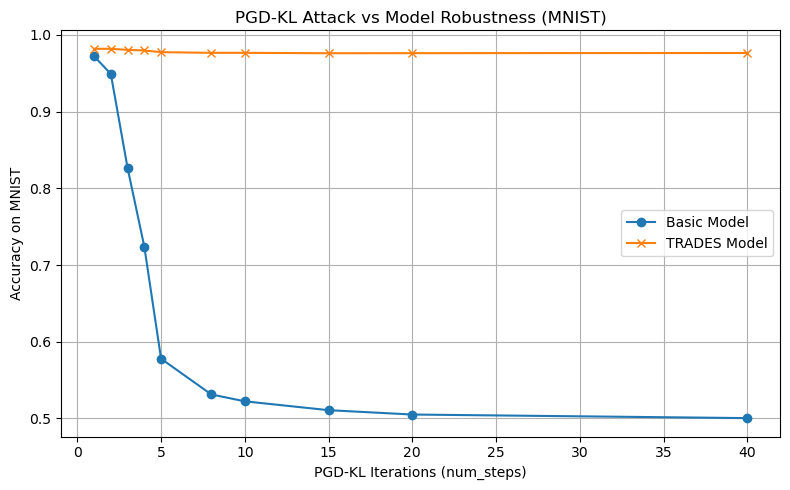

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# PGD步数设置（不均匀）
step_list = [1, 2, 3, 4, 5, 8, 10, 15, 20, 40]

# 构建两个 runner
basic_optimizer = Adam(model=basicmodel, lr=0.001)
basic_loss_fn = CrossEntropy(model=basicmodel)
basic_runner = RunnerM(model=basicmodel, loss=basic_loss_fn, optimizer=basic_optimizer)

adv_optimizer = Adam(model=advmodel, lr=0.001)
adv_loss_fn = CrossEntropy(model=advmodel)
adv_runner = RunnerM(model=advmodel, loss=adv_loss_fn, optimizer=adv_optimizer)

# 存储准确率
basic_acc_list = []
adv_acc_list = []

# PGD-KL 攻击强度随 steps 变化
for steps in tqdm(step_list, desc="PGD-KL Attack on MNIST"):
    # 基础模型攻击
    adv_test_images = pgd_kl_attack(
        model=basicmodel,
        images=test_images,
        epsilon=20/255,
        num_steps=steps,
        step_size=4/255,
        batch_size=128
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # TRADES 模型攻击
    adv_test_images = pgd_kl_attack(
        model=advmodel,
        images=test_images,
        epsilon=20/255,
        num_steps=steps,
        step_size=4/255,
        batch_size=128
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(step_list, basic_acc_list, label="Basic Model", marker='o')
plt.plot(step_list, adv_acc_list, label="TRADES Model", marker='x')
plt.xlabel("PGD-KL Iterations (num_steps)")
plt.ylabel("Accuracy on MNIST")
plt.title("PGD-KL Attack vs Model Robustness (MNIST)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('trades_curve/PGD_KL_minst')
plt.show()


against fgsm

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm

basic_optimizer = Adam(model=basicmodel, lr=0.001)
basic_loss_fn = CrossEntropy(model=basicmodel)
basic_runner = RunnerM(model=basicmodel, loss=basic_loss_fn, optimizer=basic_optimizer)
adv_optimizer = Adam(model=advmodel, lr=0.001)
adv_loss_fn = CrossEntropy(model=advmodel)
adv_runner = RunnerM(model=advmodel, loss=adv_loss_fn, optimizer=adv_optimizer)

Evaluating FGSM at different epsilons: 100%|██████████| 25/25 [06:13<00:00, 14.94s/it]


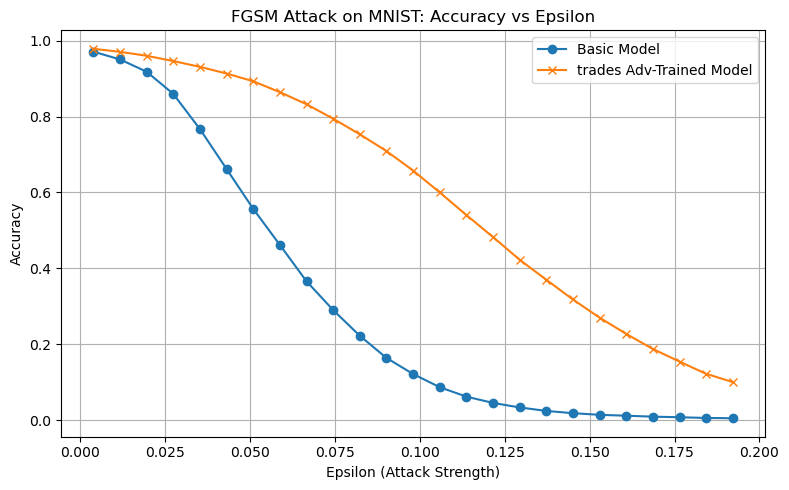

In [11]:


# epsilon 范围
epsilons = [i / 255.0 for i in range(1, 51, 2)]

# 记录精度
basic_acc_list = []
adv_acc_list = []

# tqdm进度条
for eps in tqdm(epsilons, desc="Evaluating FGSM at different epsilons"):

    # Basic Model FGSM
    adv_test_images = fgsm_attack(
        model=basicmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=basic_loss_fn,
        epsilon=eps
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # Adv Model FGSM
    adv_test_images = fgsm_attack(
        model=advmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=adv_loss_fn,
        epsilon=eps
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(epsilons, basic_acc_list, label='Basic Model', marker='o')
plt.plot(epsilons, adv_acc_list, label='trades Adv-Trained Model', marker='x')
plt.xlabel('Epsilon (Attack Strength)')
plt.ylabel('Accuracy')
plt.title('FGSM Attack on MNIST: Accuracy vs Epsilon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('trades_curve/trades_fgsm_minst')
plt.show()

against BIM

In [11]:
from mynn.attack import bim_attack
# epsilon 范围
step_list = [1, 2, 3, 4, 5, 8, 10, 15, 20, 40]

# 记录精度
basic_acc_list = []
adv_acc_list = []

# tqdm进度条
for step in tqdm(step_list, desc="Evaluating BIM at different steps"):

    # Basic Model FGSM
    adv_test_images = bim_attack(
        model=basicmodel,
        images=test_images, 
        labels=test_labels, 
        loss_fn=basic_loss_fn,
        epsilon=20/255,
        num_steps=step,
        step_size=4/255
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # Adv Model FGSM
    adv_test_images = bim_attack(
        model=advmodel,
        images=test_images, 
        labels=test_labels, 
        loss_fn=adv_loss_fn,
        epsilon=20/255,
        num_steps=step,
        step_size=4/255
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)



Evaluating BIM at different steps: 100%|██████████| 10/10 [14:58<00:00, 89.85s/it] 


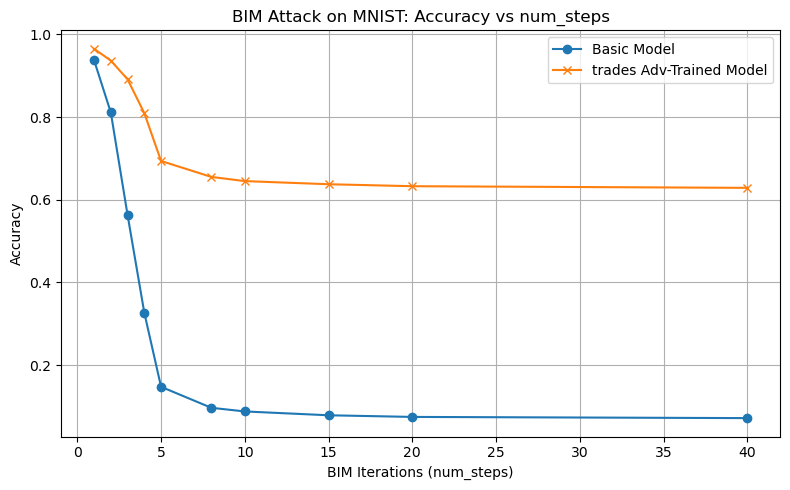

In [12]:
# 绘图
plt.figure(figsize=(8, 5))
plt.plot(step_list, basic_acc_list, label='Basic Model', marker='o')
plt.plot(step_list, adv_acc_list, label='trades Adv-Trained Model', marker='x')
plt.xlabel('BIM Iterations (num_steps)')
plt.ylabel('Accuracy')
plt.title('BIM Attack on MNIST: Accuracy vs num_steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('trades_curve/trades_BIM_minst')
plt.show()

against PGD

In [14]:
step_list = [1, 2, 3, 4, 5, 8, 10, 15, 20, 40]

# 记录精度
basic_acc_list = []
adv_acc_list = []

# tqdm进度条
for step in tqdm(step_list, desc="Evaluating PGD at different steps"):

    # Basic Model FGSM
    adv_test_images = pgd_attack(
        model=basicmodel,
        images=test_images, 
        labels=test_labels, 
        loss_fn=basic_loss_fn,
        epsilon=20/255,
        num_steps=step,
        step_size=4/255
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # Adv Model FGSM
    adv_test_images = pgd_attack(
        model=advmodel,
        images=test_images, 
        labels=test_labels, 
        loss_fn=adv_loss_fn,
        epsilon=20/255,
        num_steps=step,
        step_size=4/255
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)

Evaluating PGD at different steps: 100%|██████████| 10/10 [12:32<00:00, 75.27s/it] 


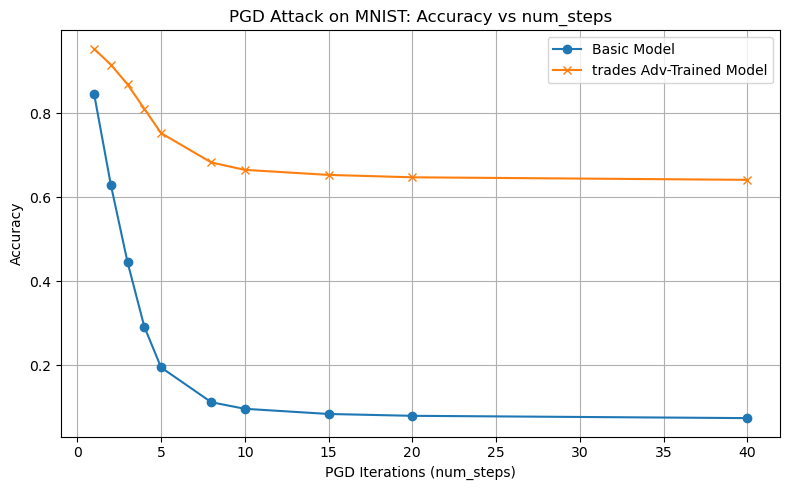

In [15]:
# 绘图
plt.figure(figsize=(8, 5))
plt.plot(step_list, basic_acc_list, label='Basic Model', marker='o')
plt.plot(step_list, adv_acc_list, label='trades Adv-Trained Model', marker='x')
plt.xlabel('PGD Iterations (num_steps)')
plt.ylabel('Accuracy')
plt.title('PGD Attack on MNIST: Accuracy vs num_steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('trades_curve/trades_PGD_minst')
plt.show()

## cifar10

In [17]:
basicmodel= Model().load_model('best_model_basic/VGG-base-train/best_model.pickle')
advmodel= Model().load_model('best_model_trades/beta2/best_model.pickle')

Model loaded from: best_model_basic\VGG-base-train\best_model.pickle
Model loaded from: best_model_trades\beta2\best_model.pickle


In [19]:
from mynn.attack import bim_attack

basic_optimizer = Adam(model=basicmodel, lr=0.001)
loss_fn = CrossEntropy(model=basicmodel)
runner = RunnerM(model=basicmodel, loss=loss_fn, optimizer=basic_optimizer)

adv_test_images = bim_attack(
    model=basicmodel,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=2 / 255,
    num_steps=5,
    step_size=0.5 / 255
)

test_set_adv = (adv_test_images, test_labels)

adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 7.81225, Test accuracy: 0.38370


In [20]:
from mynn.attack import bim_attack

basic_optimizer = Adam(model=basicmodel, lr=0.001)
loss_fn = CrossEntropy(model=basicmodel)
runner = RunnerM(model=basicmodel, loss=loss_fn, optimizer=basic_optimizer)

adv_test_images = bim_attack(
    model=basicmodel,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=8 / 255,
    num_steps=10,
    step_size=1 / 255
)

test_set_adv = (adv_test_images, test_labels)

adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 16.43825, Test accuracy: 0.00059


In [22]:
from mynn.attack import pgd_attack

basic_optimizer = Adam(model=basicmodel, lr=0.001)
loss_fn = CrossEntropy(model=basicmodel)
runner = RunnerM(model=basicmodel, loss=loss_fn, optimizer=basic_optimizer)

adv_test_images = pgd_attack(
    model=basicmodel,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=2/ 255,
    num_steps=5,
    step_size=0.5 / 255
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 7.00396, Test accuracy: 0.43097


In [23]:
from mynn.attack import pgd_attack

basic_optimizer = Adam(model=basicmodel, lr=0.001)
loss_fn = CrossEntropy(model=basicmodel)
runner = RunnerM(model=basicmodel, loss=loss_fn, optimizer=basic_optimizer)

adv_test_images = pgd_attack(
    model=basicmodel,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=8/ 255,
    num_steps=10,
    step_size=1 / 255
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 16.18532, Test accuracy: 0.00386


PGD-KL Attack on CIFAR-10: 100%|██████████| 7/7 [1:19:08<00:00, 678.32s/it]


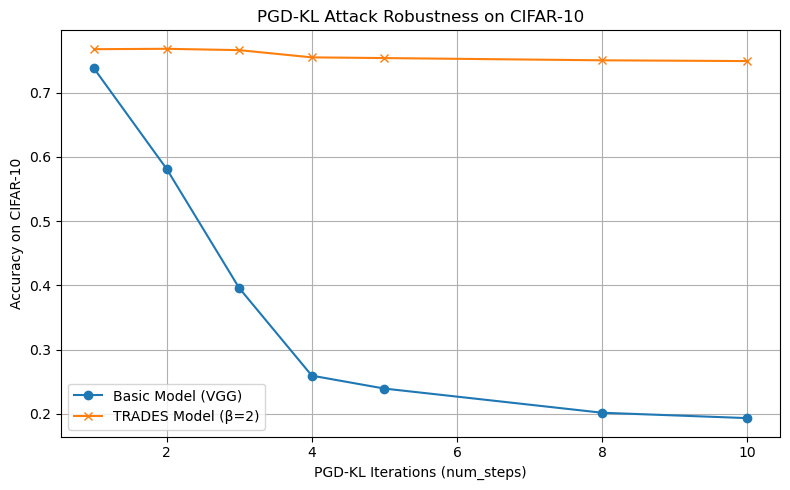

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# CIFAR-10 的 PGD 迭代步数列表（不均匀）
# step_list = [1, 2, 3, 4, 5, 8, 10, 20]
step_list = [1, 2, 3, 4, 5, 8, 10] 
# 初始化两个模型的 Runner
basic_optimizer = Adam(model=basicmodel, lr=0.001)
basic_loss_fn = CrossEntropy(model=basicmodel)
basic_runner = RunnerM(model=basicmodel, loss=basic_loss_fn, optimizer=basic_optimizer)

adv_optimizer = Adam(model=advmodel, lr=0.001)
adv_loss_fn = CrossEntropy(model=advmodel)
adv_runner = RunnerM(model=advmodel, loss=adv_loss_fn, optimizer=adv_optimizer)

# 结果保存列表
basic_acc_list = []
adv_acc_list = []

# 执行 PGD-KL 攻击测试
for steps in tqdm(step_list, desc="PGD-KL Attack on CIFAR-10"):
    # Basic model
    adv_test_images = pgd_kl_attack(
        model=basicmodel,
        images=test_images,
        epsilon=2/255,
        num_steps=steps,
        step_size=0.5/255,
        batch_size=128,
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # TRADES model
    adv_test_images = pgd_kl_attack(
        model=advmodel,
        images=test_images,
        epsilon=2/255,
        num_steps=steps,
        step_size=0.5/255,
        batch_size=128,
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)

# 可视化结果
plt.figure(figsize=(8, 5))
plt.plot(step_list, basic_acc_list, marker='o', label="Basic Model (VGG)")
plt.plot(step_list, adv_acc_list, marker='x', label="TRADES Model (β=2)")
plt.xlabel("PGD-KL Iterations (num_steps)")
plt.ylabel("Accuracy on CIFAR-10")
plt.title("PGD-KL Attack Robustness on CIFAR-10")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('trades_curve/PGD_KL_cifar10')
plt.show()



against fgsm

Evaluating FGSM on CIFAR-10: 100%|██████████| 10/10 [31:37<00:00, 189.77s/it]


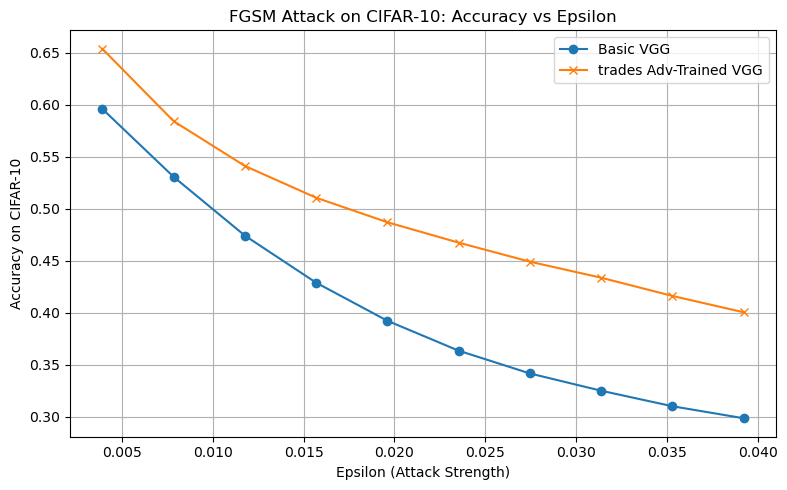

In [18]:
# 构建 runner（不需要重新加载模型）
basic_optimizer = Adam(model=basicmodel, lr=0.001)
basic_loss_fn = CrossEntropy(model=basicmodel)
basic_runner = RunnerM(model=basicmodel, loss=basic_loss_fn, optimizer=basic_optimizer)

adv_optimizer = Adam(model=advmodel, lr=0.001)
adv_loss_fn = CrossEntropy(model=advmodel)
adv_runner = RunnerM(model=advmodel, loss=adv_loss_fn, optimizer=adv_optimizer)

# epsilon 范围
epsilons = [i / 255.0 for i in range(1, 11, 1)]

# 精度记录
basic_acc_list = []
adv_acc_list = []

# 评估各 epsilon 下模型准确率
for eps in tqdm(epsilons, desc="Evaluating FGSM on CIFAR-10"):

    # 基础模型 FGSM
    adv_test_images = fgsm_attack(
        model=basicmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=basic_loss_fn,
        epsilon=eps
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # 对抗训练模型 FGSM
    adv_test_images = fgsm_attack(
        model=advmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=adv_loss_fn,
        epsilon=eps
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(epsilons, basic_acc_list, label='Basic VGG', marker='o')
plt.plot(epsilons, adv_acc_list, label='trades Adv-Trained VGG', marker='x')
plt.xlabel('Epsilon (Attack Strength)')
plt.ylabel('Accuracy on CIFAR-10')
plt.title('FGSM Attack on CIFAR-10: Accuracy vs Epsilon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('trades_curve/trades_fgsm_cifar10')
plt.show()

against BIM

In [7]:
basic_optimizer = Adam(model=basicmodel, lr=0.001)
basic_loss_fn = CrossEntropy(model=basicmodel)
basic_runner = RunnerM(model=basicmodel, loss=basic_loss_fn, optimizer=basic_optimizer)

adv_optimizer = Adam(model=advmodel, lr=0.001)
adv_loss_fn = CrossEntropy(model=advmodel)
adv_runner = RunnerM(model=advmodel, loss=adv_loss_fn, optimizer=adv_optimizer)

from mynn.attack import bim_attack
# epsilon 范围
step_list = [1, 2, 3, 4, 5, 8, 10]

# 记录精度
basic_acc_list = []
adv_acc_list = []

# tqdm进度条
for step in tqdm(step_list, desc="Evaluating BIM at different steps"):

    # Basic Model FGSM
    adv_test_images = bim_attack(
        model=basicmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=basic_loss_fn,
        epsilon=2/255,
        num_steps=step,
        step_size=0.5/255
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # Adv Model FGSM
    adv_test_images = bim_attack(
        model=advmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=adv_loss_fn,
        epsilon=2/255,
        num_steps=step,
        step_size=0.5/255,
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)



Evaluating BIM at different steps: 100%|██████████| 7/7 [1:35:01<00:00, 814.55s/it] 


NameError: name 'plt' is not defined

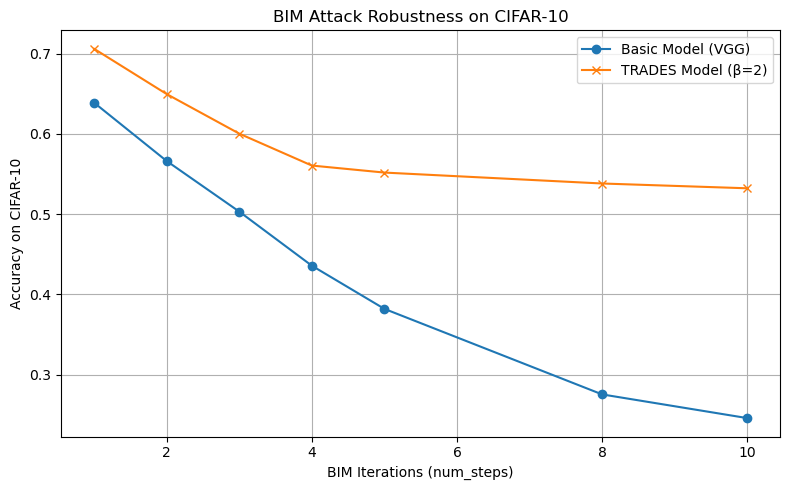

In [8]:
import  matplotlib.pyplot as plt
# 可视化结果
plt.figure(figsize=(8, 5))
plt.plot(step_list, basic_acc_list, marker='o', label="Basic Model (VGG)")
plt.plot(step_list, adv_acc_list, marker='x', label="TRADES Model (β=2)")
plt.xlabel("BIM Iterations (num_steps)")
plt.ylabel("Accuracy on CIFAR-10")
plt.title("BIM Attack Robustness on CIFAR-10")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('trades_curve/trades_BIM_cifar10')
plt.show( )

PGD

In [24]:
basic_optimizer = Adam(model=basicmodel, lr=0.001)
basic_loss_fn = CrossEntropy(model=basicmodel)
basic_runner = RunnerM(model=basicmodel, loss=basic_loss_fn, optimizer=basic_optimizer)

adv_optimizer = Adam(model=advmodel, lr=0.001)
adv_loss_fn = CrossEntropy(model=advmodel)
adv_runner = RunnerM(model=advmodel, loss=adv_loss_fn, optimizer=adv_optimizer)

from mynn.attack import bim_attack
# epsilon 范围
step_list = [1, 2, 3, 4, 5, 8, 10]

# 记录精度
basic_acc_list = []
adv_acc_list = []

# tqdm进度条
for step in tqdm(step_list, desc="Evaluating BIM at different steps"):

    # Basic Model FGSM
    adv_test_images = pgd_attack(
        model=basicmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=basic_loss_fn,
        epsilon=2/255,
        num_steps=step,
        step_size=0.5/255
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = basic_runner.evaluate(test_set_adv, batch_size=64, loss_fn=basic_loss_fn)
    basic_acc_list.append(acc)

    # Adv Model FGSM
    adv_test_images = pgd_attack(
        model=advmodel,
        images=test_images,
        labels=test_labels,
        loss_fn=adv_loss_fn,
        epsilon=2/255,
        num_steps=step,
        step_size=0.5/255,
    )
    test_set_adv = (adv_test_images, test_labels)
    _, acc = adv_runner.evaluate(test_set_adv, batch_size=64, loss_fn=adv_loss_fn)
    adv_acc_list.append(acc)

Evaluating BIM at different steps: 100%|██████████| 7/7 [1:20:10<00:00, 687.21s/it]


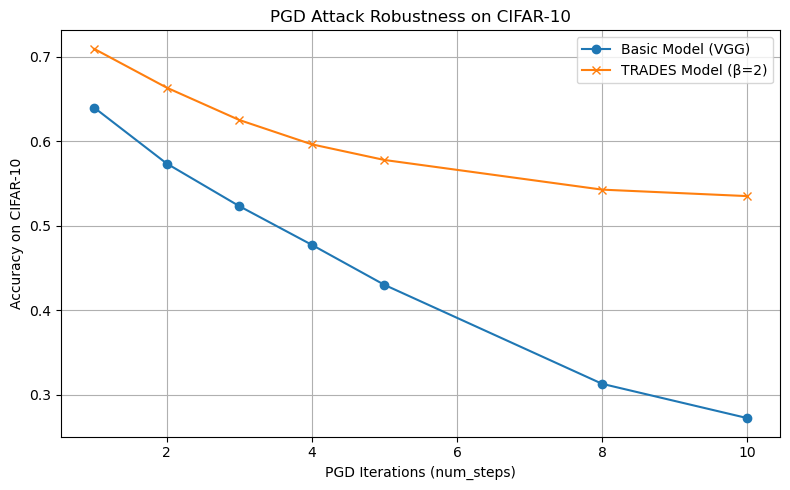

In [25]:
import  matplotlib.pyplot as plt
# 可视化结果
plt.figure(figsize=(8, 5))
plt.plot(step_list, basic_acc_list, marker='o', label="Basic Model (VGG)")
plt.plot(step_list, adv_acc_list, marker='x', label="TRADES Model (β=2)")
plt.xlabel("PGD Iterations (num_steps)")
plt.ylabel("Accuracy on CIFAR-10")
plt.title("PGD Attack Robustness on CIFAR-10")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('trades_curve/trades_PGD_cifar10')
plt.show( )